In [ ]:
# setup goole drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/rem_sense')
!pip install -r /content/drive/MyDrive/rem_sense/requirements.txt

In [2]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from src.data import Observation_dataset
from src.models import UNet
import data.data_dict as data_dict
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

data = data_dict.data_dict

### A: Dataset and Dataloader

In [3]:
# create dataset
ds = Observation_dataset(data)

100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


Shape of s2 image: torch.Size([12, 96, 96])
Shape of classes mask: torch.Size([96, 96])
Shape of rgb image: torch.Size([3, 96, 96])


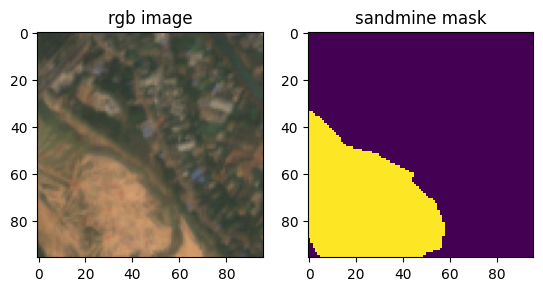

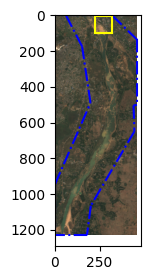

In [4]:
# check single sample
idx = 950
s2, classes, top_left_px_idx, rgb = ds.__getitem__(idx, return_rgb=True)
print(f'Shape of s2 image: {s2.shape}')
print(f'Shape of classes mask: {classes.shape}')
print(f'Shape of rgb image: {rgb.shape}')
fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].imshow(rgb.permute(1,2,0))
axs[0].set(title='rgb image')
axs[1].matshow(classes)
axs[1].set(title='sandmine mask')
plt.gca().xaxis.tick_bottom()
ds.visualize_batch([idx])

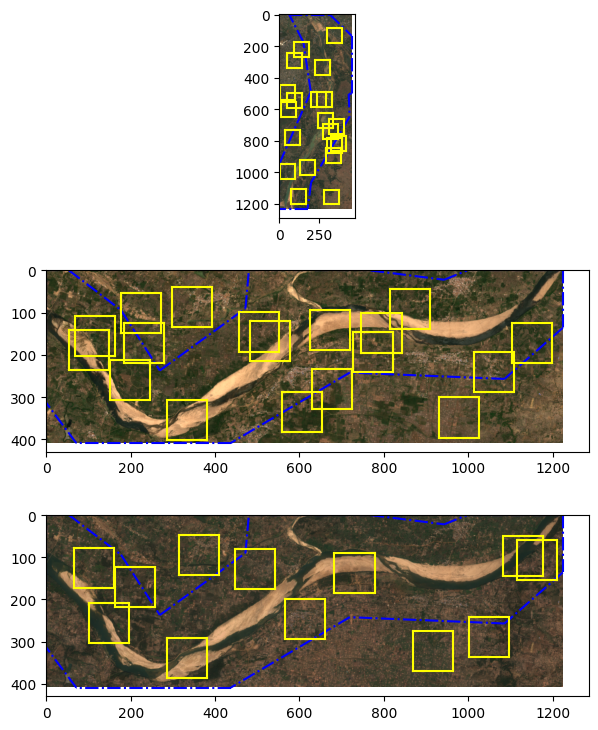

In [5]:
# check multiple samples
dl = DataLoader(ds, batch_size=50, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


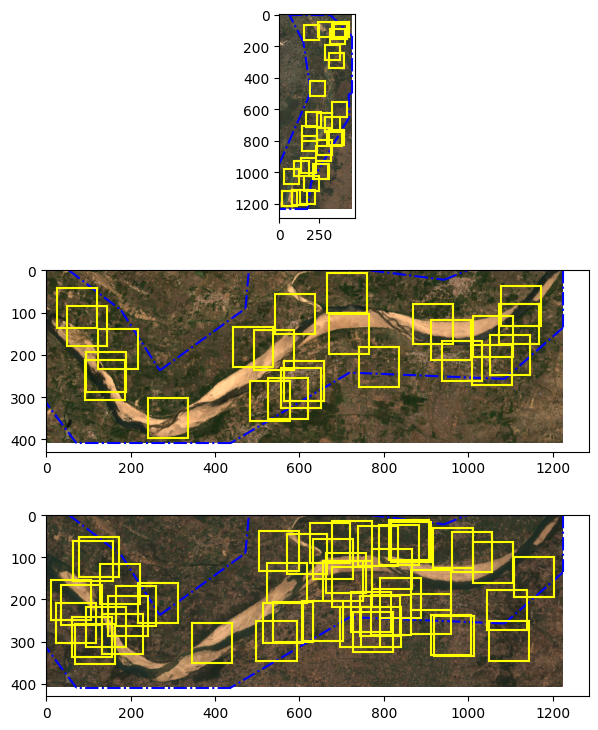

In [44]:
# stretch: only river
ds = Observation_dataset(data, only_river=True)
dl = DataLoader(ds, batch_size=100, shuffle=True)
batch = next(iter(dl))
ds.visualize_batch(batch[2])

### B: Semantic Segmentation Training

For the Semantic Segmentation Task, we use a simple U-Net architecture. U-Nets are not state of the art anymore, but have performed very well in the past. We use this architecture here, since we can easily implement it by hand. However, for getting good predictions, we should use advanced architectures like specialized transformers. Below is a schematic sketch of a vanilla U-Net architecture (source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/, sometimes the image might not be shown due to a bug but you can also find the image in `/data/u-net-architecture.png`). In our case, the initial spatial dimensions are 96x96, the initial input channels are 12, and we only have 2 down/up-sampling steps (16,32).
![u-net-architecture](data%u-net-architecture.png)

In [45]:
# check model output shape
ds = Observation_dataset(data[:1])
dl = DataLoader(ds, batch_size=7, shuffle=True)
model = UNet()

print(f'Number of parameters: {sum(param.numel() for param in model.parameters())}')
batch = next(iter(dl))
model.float()
out = UNet()(batch[0].float())
print(f'Output shape: {out.shape}')

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

Number of parameters: 57249
Output shape: torch.Size([7, 96, 96])


In [14]:
from src.models import Pl_wrapper
from pytorch_lightning import Trainer

# Simple training loop with pytorch lightning framework
model = UNet()
ds = Observation_dataset(data)
ds.to('cuda') # only possible since dataset is small
dl = DataLoader(ds, batch_size=32, num_workers=2, pin_memory=True)
pl_module = Pl_wrapper(model)
trainer = Trainer(accelerator='cuda', max_epochs=1)
trainer.fit(pl_module, dl)



100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | model    | UNet    | 57.2 K
1 | loss_fct | BCELoss | 0     
2 | sigm     | Sigmoid | 0     
-------------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model par

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [16]:
# save model
torch.save(model.state_dict(), '/content/drive/MyDrive/rem_sense/weights/nepochs=1.pt')

### C: Evaluation


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


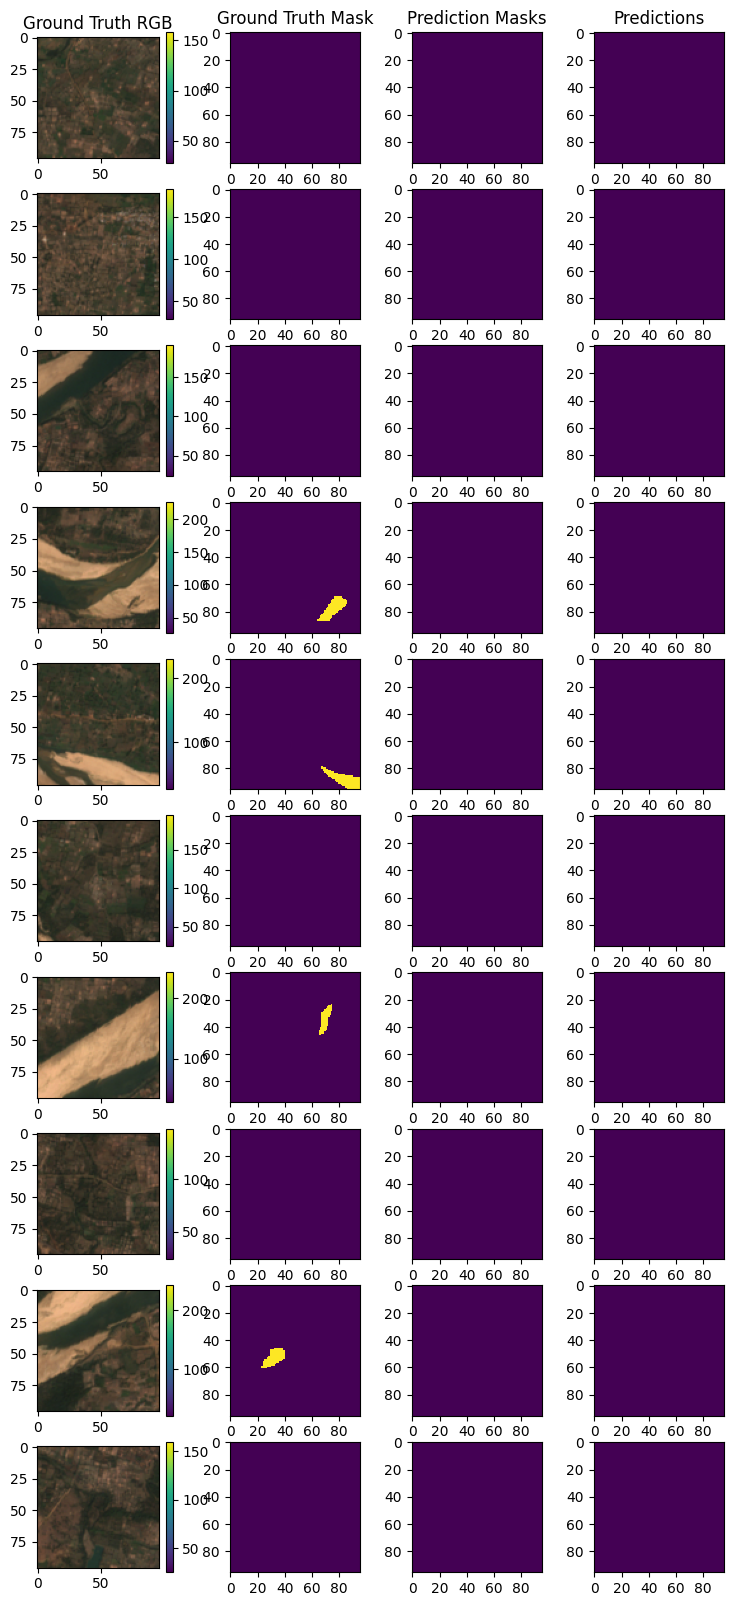

In [17]:
from torch.nn.functional import sigmoid

# params
device = 'cpu'
n_samples = 10

# load data
train_ds = Observation_dataset(data[:2])
test_ds = Observation_dataset(data[2:])
test_dl = DataLoader(test_ds, batch_size=n_samples, shuffle=True)
batch = next(iter(test_dl))

# make predictions
model.eval()
model.to(device)
with torch.no_grad():
    preds = sigmoid(model(batch[0].to(device)))
targets = batch[1]

# plotting
nrows, ncols = n_samples, 4
plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,2*nrows))
for i in range(n_samples):
    plt.subplot(nrows,ncols, ncols*i + 1)
    _,_,_,gt_rgb = test_ds.__getitem__(batch[2][i], return_rgb=True)
    plt.imshow(gt_rgb.permute(1,2,0))
    if i == 0:
        plt.title('Ground Truth RGB')

    plt.subplot(nrows,ncols, ncols*i + 2)
    plt.gca().matshow(targets[i])
    plt.gca().xaxis.tick_bottom()
    if i == 0:
        plt.title('Ground Truth Mask')

    plt.subplot(nrows,ncols, ncols*i + 3)
    plt.gca().matshow( (preds[i] >= 0.5).int() )
    plt.gca().xaxis.tick_bottom()
    if i == 0:
        plt.title('Prediction Masks')

    plt.subplot(nrows,ncols, ncols*i + 4)
    plt.gca().matshow(preds[i])
    plt.gca().xaxis.tick_bottom()
    plt.colorbar()
    if i == 0:
        plt.title('Predictions')

100%|██████████| 11079/11079 [03:30<00:00, 52.58it/s]


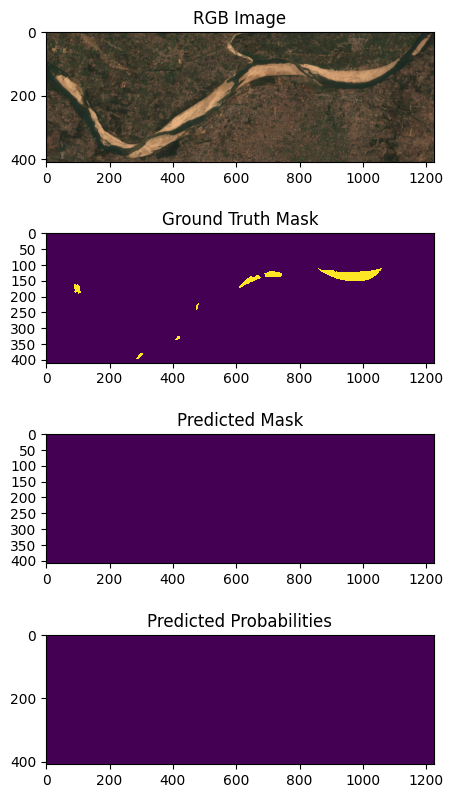

Maximum probability: 0.0


In [43]:
# Stretch: predict&reconstruct full image
batch_size = 32
device = 'cuda'
test_dl = DataLoader(test_ds, batch_size=batch_size)
counts_all = torch.zeros(test_ds.data[0]['data_rgb'].shape[1:3]).to(device)
preds_all = torch.zeros_like(counts_all).to(device)

# compute predictions
model.eval()
model.to(device)
with torch.no_grad():
    for batch in tqdm(test_dl, position=0, leave=True):
        preds = sigmoid(model(batch[0].to(device)))
        for i in range(len(batch[2])):
            _, idx_height, idx_width = test_ds._idx2obsheightwidth(batch[2][i])
            counts_all[ idx_height:idx_height+test_ds.sample_height,
                    idx_width:idx_width+test_ds.sample_width ] += 1
            preds_all[ idx_height:idx_height+test_ds.sample_height,
                    idx_width:idx_width+test_ds.sample_width ] += preds[i]
preds_all = preds_all / counts_all

# plotting
fig, axs = plt.subplots(nrows=4,ncols=1, figsize=(5, 10))
rgb = test_ds.data[0]['data_rgb']
classes = test_ds.data[0]['data_classes']
axs[0].imshow(rgb.permute(1,2,0))
axs[0].set(title='RGB Image')
axs[1].matshow(classes)
axs[1].set(title='Ground Truth Mask')
axs[1].xaxis.tick_bottom()
axs[2].matshow((preds_all > 0.5).int().detach().cpu().numpy())
axs[2].set(title='Predicted Mask')
axs[2].xaxis.tick_bottom()
plt.subplot(414)
plt.gca().imshow((preds_all).detach().cpu().numpy())
plt.title('Predicted Probabilities')
plt.show()
print(f'Maximum probability: {preds_all.max()}')

Final thoughts:
- The model does not predict a single pixel as 1, I guess that is due to there only being 1 training episode and most of the targets being 0
- Finding a suitable library for converting the `.geojson` file into pixels took me a bit of time. I first looked into `rastervision`, but that seemed too packed for our purposes. Then I encountered `rasterio` and that seemed perfect.